# Tow Sigma Connect - Rental listing challenge

This python notebook explores a solution to above challenge in [Kaggle](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries)

The data files are located in `../data` but it does not include all the images, just the ones listed in the challenge.

## Data definition

There are two files, `train.json` and `test.json`. It is a dictionary of different _columns_. Each of those is in turn another dictionary where the keys are property IDs and the values are the corresponding values for that _column_. This format is available in [pandas.read_json](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html) and we will use that library to load the data.

In [1]:
import pandas
training_data = pandas.read_json('../data/train.json', orient='columns')

We can get a list of all available column values

In [2]:
list(training_data)

['bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'interest_level',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address']

The target variable is `interest_level`, which contains the values "low", "medium", "high". The challenge in Kaggle is defined as a multiclass classification problem and the submissions were evaluated using multi-class logarithmic loss. This is at odds with the fact that the classes constitute an ordinal value and this structure could be exploited by a predictor but we will stick with that in our modelling. Let's quickly map those classes into three columns and get some descriptive statistics.

In [3]:
for klass in ['low', 'medium', 'high']:
    klass_name = 'klass_%s' % klass
    fun_klass = lambda v: (1 if v == klass else 0)
    training_data[klass_name] = training_data['interest_level'].map(fun_klass, na_action='ignore')

# output summary statistics for numeric columns
training_data.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price,klass_low,klass_medium,klass_high
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04,49352.000000,49352.000000,49352.000000
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03,0.694683,0.227529,0.077788
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04,0.460546,0.419241,0.267841
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01,0.000000,0.000000,0.000000
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03,0.000000,0.000000,0.000000
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03,1.000000,0.000000,0.000000
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03,1.000000,0.000000,0.000000
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06,1.000000,1.000000,1.000000


At a glance, we see the overall probabilities for each class, $P(low) = 0.695$, $P(medium) = 0.228$ and $P(high) = 0.078$ - a highly unbalanced classification.

In [4]:
print(training_data.groupby('interest_level').size())

interest_level
high       3839
low       34284
medium    11229
dtype: int64


To start with, let's plot scatter matrices for these three classes for bathrooms, bedrooms and price.

Scatter matrix - Low interest class


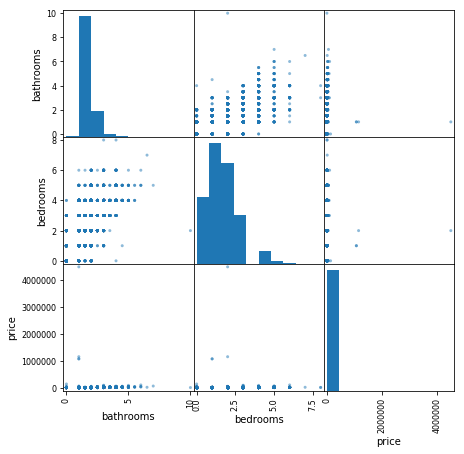

In [5]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
axs = scatter_matrix(training_data[training_data.interest_level == 'low'][['bathrooms', 'bedrooms', 'price']], figsize=(7,7))
print('Scatter matrix - Low interest class')
plt.show()

Scatter matrix - Medium interest class


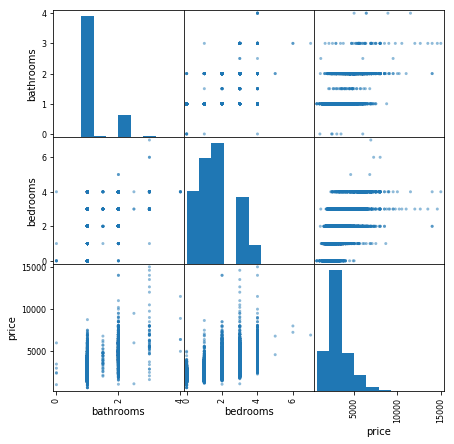

In [6]:
axs = scatter_matrix(training_data[training_data.interest_level == 'medium'][['bathrooms', 'bedrooms', 'price']], figsize=(7,7))
print('Scatter matrix - Medium interest class')
plt.show()

Scatter matrix - High interest class


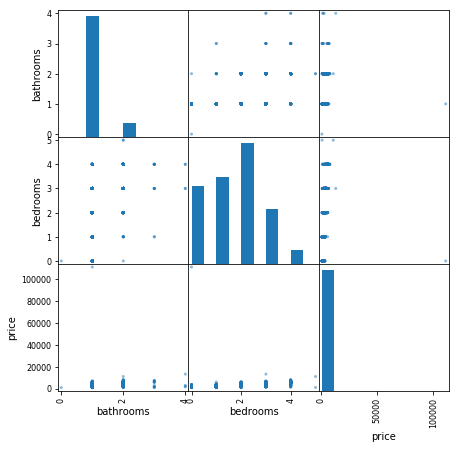

In [7]:
axs = scatter_matrix(training_data[training_data.interest_level == 'high'][['bathrooms', 'bedrooms', 'price']], figsize=(7,7))
print('Scatter matrix - High interest class')
plt.show()

We note that at low interest level number of bathrooms equal to 1, whereas for medium and high is bigger. The number of bedrooms seems important for low and medium levels, but for high appears in a particular distribution. Also, price is spread for medium interest, but seems highly concentrated for other classes. Overall, these matrix scatter plots seem to justify to an extend the loss model adopted by renthop.com.

Finally, here an scatter plot of the categories using latitude and longitude (we discarded some data points that were zeros)

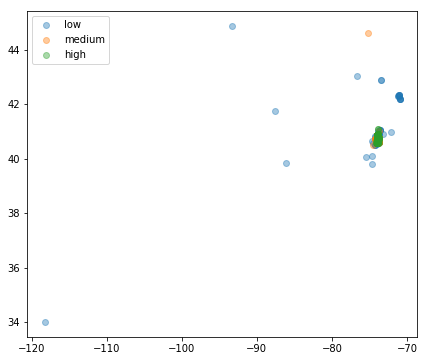

In [8]:
def plot_lat_lon():
    global training_data
    data = training_data[(training_data.longitude < 0) & (training_data.latitude > 0)]
    plt.figure(figsize=(7,6))
    for klass in ['low', 'medium', 'high']:
        subdata = data[data.interest_level == klass]
        plt.scatter(subdata['longitude'], subdata['latitude'], alpha=0.4)
    plt.legend(['low', 'medium', 'high'])
    plt.show()
plot_lat_lon()

We see that geolocation is important for high interest: only listings close to a certain location can be of high interest.

## Random forrest model

We pick as independent variables `bathrooms` ($X_{ba}$), `bedrooms` ($X_{be}$), `price` ($X_{pr}$), `latitude` ($X_{la}$) and `longitude` ($X_{lo}$) to define a model based on Random Forest which is part of [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). This choice is motivated by the plots above, that show that simple splits on few variables may suffice to classify the points in the data - an approach suitable for decision trees.

RandomForrest in sklearn has two convinience methods that serve our purposes. The method `predict_proba` is what we would need to submit an entry to the Kaggle challenge. On the other hand, `predict` returns the predicted classes, so we can directly compare against a training dataset.

In [9]:
from sklearn.ensemble import RandomForestClassifier

class Model1(object):
    """An application of RandomForestClassifier for the renthop.com data"""
    def fit(self, data):
        """Trains the classifier with given DataFrame"""
        xs = data[['bathrooms', 'bedrooms', 'price', 'latitude', 'longitude']].as_matrix()
        self.rfc = RandomForestClassifier(max_features=None)
        self.rfc.fit(xs, data.interest_level)

    def probabilities(self, points):
        """Calculate probabilites for each classification of points.

        Returns:
            DataFrame:
                A pandas dataframe with columsn per class and rows correspoding
                probabilities for each point in points
        """
        df = pandas.DataFrame(self.rfc.predict_proba(points), columns=self.rfc.classes_)
        return df

    def classify(self, points):
        """Perform direct classification picking the class with highest probability"""
        return self.rfc.predict(points)

    def log_probabilities(self, points):
        """Similar to `probabilities` but returns logarithms."""
        df = pandas.DataFrame(-self.rfc.predict_log_proba(points), columns=self.rfc.classes_)
        return df


# Train the model on a subset of the training data for illustrative purposes
mod1 = Model1()
mod1.fit(training_data.iloc[0:40000])

## Evaluate model

To finalise, we calculate an overall accuracy value for the model as defined in the Kaggle challenge passing the model through unseen data.

In [10]:
import numpy as np
LEVEL_TO_ARRAY = dict(low=[1,0,0], medium=[0,1,0], high=[0,0,1])

def logloss(model, test_data):
    coords = test_data[['bathrooms', 'bedrooms', 'price', 'latitude', 'longitude']].as_matrix()
    test_classes = np.array(list(map(lambda v: LEVEL_TO_ARRAY[v], list(test_data.interest_level))))
    logprobs = model.log_probabilities(coords)[['low', 'medium', 'high']].as_matrix()
    logprobs[logprobs == np.inf] = 0
    logprobs[logprobs == np.nan] = 0
    prod = np.multiply(test_classes, logprobs)
    return (np.nansum(prod) / test_data.shape[0])

print('Score %f' % logloss(mod1, training_data.iloc[40000:]))

Score 0.515548


/opt/ds/lib/python3.4/site-packages/sklearn/ensemble/forest.py:620: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


This is comparable to the winner score (actually higher) but there are many things to do before we can be sure the model performs well. First, we are not sure if the model is overfitting the data. A better strategy would be to use k-fold cross validation to fine tune a number of parameters required by RandomForest, e.g. the number of estimators.

Also, we did not use any of the text features! If further improvements can be achieved over RandomForrest by extracting additional features from descriptions and text then the model will may improve beyond the best in the leader board.